In [172]:
#Input parameters
weatherStationSerial = "BWEATHER-3"
citySerial = "Loudeac"
pPlantSerial = "JPP-S-1"
batterySerial = "JPP-S-BS"
energyTraderSerial = "ET-1"
#Example parameter string for default parameters {"weatherStationSerial":"BWEATHER-1","citySerial":"Loudeac","pPlantSerial":"JPP-1","batterySerial":"BAT-1"}
#                                                {"weatherStationSerial":"BWEATHER-1","citySerial":"Loudeac","pPlantSerial":"JPP-S-1","batterySerial":"BAT-S-1"}



In [173]:
#Dynamically fetch the correct battery
pPlantToBatSerialDict = {"1":'BS',
                         "2":'BM',
                         "3":'BL'}

pPlantSerialArray = pPlantSerial.split("-")
pPlantSerialArray[2] = pPlantToBatSerialDict[pPlantSerialArray[2]]


In [174]:
batterySerial = "-".join(pPlantSerialArray)

JPP-S-BM


In [64]:
!pip install --upgrade git+https://alroc@bitbucket.org/freemens/ionlib.git@master

  Running command git clone -q 'https://****@bitbucket.org/freemens/ionlib.git' 'C:\Users\gcoll\AppData\Local\Temp\pip-req-build-z6s51clh'



  Cloning https://****@bitbucket.org/freemens/ionlib.git (to revision master) to c:\users\gcoll\appdata\local\temp\pip-req-build-z6s51clh


In [65]:
!pip install -qqq --upgrade git+https://bitbucket.org/freemens/ion_sdk.git@master

In [66]:
!pip install -qqq --upgrade pandas
!pip install -qqq --upgrade numpy

In [67]:
%env ALTERGO_FACTORY_API = https://staging.altergo.io/
%env ALTERGO_IOT_API = https://iot.staging.altergo.io/   

env: ALTERGO_FACTORY_API=https://staging.altergo.io/
env: ALTERGO_IOT_API=https://iot.staging.altergo.io/


In [121]:
from ionlib.models.battery import Battery, Cell, LEVEL_MODULE
from random import random
from datetime import datetime
from ionlib.tools.toolbox import interpolateValue

In [122]:
from ionlib.models.battery import Battery, Cell, LEVEL_MODULE
from ionlib.models.powerplant import PowerPlant,SolarArray
import pandas as pd
import ion_sdk.edison_api.edison_api as eapi
from ion_sdk.edison_api.models.factoryModel import EdisonGenericComponent, Model,CurrentState
from ion_sdk.tools.toolbox import plotSensors, dataframeFromSensors
from ion_sdk.tools.sim import Sensor
import datetime
from datetime import datetime
import math
from ionlib.specs.powerplant_specs import simSpecs
import pprint


In [123]:
edApi = eapi.Client("f6ad4f7166814976b66b9cb346ebc5dd")

In [124]:
powerPlantAsset = edApi.getAsset(pPlantSerial)
solarPanelSurface = powerPlantAsset.model.parameters[0].parameter_values[0].value


In [125]:
batteryAsset = edApi.getAsset(batterySerial)

batteryVoltage = 400
batteryCapacity = 50
neededParameters = ["Voltage","Capacity","Current (charge)","Current (discharge)"]
parameterDict = {}
for param in batteryAsset.model.parameters:
    if param.parameter_model.name in neededParameters:
        parameterDict[param.parameter_model.name] = param.parameter_values[0].value
        


In [126]:
print(parameterDict)

{'Voltage': '200', 'Capacity': '200', 'Current (charge)': '20000', 'Current (discharge)': '40000'}


In [127]:
moduleInSeries = float(parameterDict["Voltage"])/float(simSpecs['cell']['voltage']) / float(simSpecs['architecture']['cellsSeries'])
moduleInSeries = math.ceil(moduleInSeries)

moduleInPar=float(parameterDict["Capacity"])/float(simSpecs['cell']['cellCapacity'])/14
moduleInPar = math.ceil(moduleInPar)

simSpecs['architecture']["modulesSeries"] = moduleInSeries
simSpecs['architecture']["modulesParallel"] = moduleInPar

In [128]:
weatherStationAsset = edApi.getAsset(weatherStationSerial)
sensorNameList = edApi.matchSensors(["Direct radiation","Radiation rolling average"],weatherStationAsset)
req={
    "assets":[weatherStationAsset],
    "sensorNames":sensorNameList,
    "startDate":eapi.edisonDate(2020,1,1,0,00),
    "endDate":eapi.edisonDate(2020,12,31,0,00)
        }

edApi.getAssetDataFrame(**req)

weatherStationDf = weatherStationAsset.df

('Direct radiation', 100)
('Radiation rolling average', 100)
getting sensors: Direct radiation-Radiation rolling average from: 2019-12-31 23:00:00 UTC to : 2020-12-30 23:00:00 UTC
[##############################] 100%

In [129]:
print(weatherStationDf)

                     Direct radiation  Radiation rolling average
date                                                            
2020-01-01 00:00:00           0.00000                        NaN
2020-01-01 08:00:00           0.00000                        NaN
2020-01-01 09:00:00          20.47000                        NaN
2020-01-01 10:00:00         134.39000                        NaN
2020-01-01 11:00:00         239.41000                        NaN
...                               ...                        ...
2020-12-30 14:00:00         226.06000                  56.027619
2020-12-30 15:00:00         145.95999                  55.852797
2020-12-30 16:00:00         135.28000                  55.985238
2020-12-30 17:00:00          24.92000                  56.017023
2020-12-30 18:00:00           0.00000                  56.017023

[5436 rows x 2 columns]


In [130]:
from datetime import timedelta

In [131]:
quantile = weatherStationDf["Radiation rolling average"].quantile(.1)
result_index = weatherStationDf['Radiation rolling average'].sub(quantile).abs().idxmin()
pollingStartDate = result_index.timestamp()* 1000
pollingEndDate = result_index + timedelta(days=7)
pollingEndDate = pollingEndDate.timestamp() * 1000


In [132]:
print(pollingStartDate)
print(pollingEndDate)


1579687200000.0
1580292000000.0


In [133]:
traderAsset = edApi.getAsset(energyTraderSerial)
sensorNameList = edApi.matchSensors(["Price"],traderAsset)
req={
    "assets":[traderAsset],
    "sensorNames":sensorNameList,
    "startDate":eapi.edisonDate(2021,10,6,0,00),
    "endDate":eapi.edisonDate(2021,10,16,0,00)
        }

edApi.getAssetDataFrame(**req)

traderAssetDf = traderAsset.df

('Price', 100)
getting sensors: Price from: 2021-10-05 22:00:00 UTC to : 2021-10-15 22:00:00 UTC
[##############################] 100%

In [134]:
cityAsset = edApi.getAsset(citySerial)
sensorNameList = edApi.matchSensors(["Power"],cityAsset)
req={
    "assets":[cityAsset],
    "sensorNames":sensorNameList,
    "startDate":pollingStartDate,
    "endDate":pollingEndDate
        }

edApi.getAssetDataFrame(**req)

cityDf = cityAsset.df

('Power', 100)
getting sensors: Power from: 2020-01-22 10:00:00 UTC to : 2020-01-29 10:00:00 UTC
[##############################] 100%

In [135]:
print(simSpecs["start"])

1633564800.0


In [150]:
SIM_TARGETED_DEPTH = LEVEL_MODULE
simTime = pollingEndDate / 1000
t = pollingStartDate / 1000
dt_s = 60.0
prev_dt_s = 60.0
time = []

pPlant = PowerPlant(sourceProfile = weatherStationDf, loadProfile = cityDf, simSpecs = simSpecs, prices=traderAssetDf)

pPlant.solarArray.surface = float(solarPanelSurface)
pPlant.maxAcp = float(parameterDict['Current (charge)'])
pPlant.maxAdp = float(parameterDict['Current (discharge)'])

|    | Name          | Type   | Conditions    |      Value | Unit   |
|----|---------------|--------|---------------|------------|--------|
|  0 | Cell in S     |        |               |     5      |        |
|  1 | Cell in P     |        |               |    56      |        |
|  2 | Modules in P  |        |               |     4      |        |
|  3 | Modules in S  |        |               |     5      |        |
|  4 | Stacks in P   |        |               |     1      |        |
|  5 | Stacks in S   |        |               |     1      |        |
|  6 | Capacity      | Nom.   | 25°C, C/2     |   224      | A.h    |
|  7 | Voltage       | Nom.   | 25°C, 50% SOC |   240.5    | V      |
|  8 | DC Resistance | Nom.   | 25°C, 50% SOC |     0.0232 | Ohm    |
|  9 | Power Loss    | Typ.   | 1C,50% SOC    |     0      | W      |
| 10 | Short-Circuit | Typ.   | 500us,50% SOC | 10360      | A      |
| 11 | Specific Heat | Typ.   | Lithium cells |   800      | J/K/kg |
| 12 | Mass         

In [151]:
analysedElements = []
pPlant.battery.getElementsByDepth(analysedElements, SIM_TARGETED_DEPTH)

In [152]:
pPlantSensors = {}
batterySensors = {}
loadSensors = {}
tradingSensors = {}

pPlantSensors["sales"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)

pPlantSensors["production potential"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["demand potential"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["production actual"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["power"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["over production"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["blackout"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 2,
        "synced": 1,
        "plotted": 1,
    }
)




In [153]:
batterySensors["current"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "A",
        "axis": 2,
        "synced": 1,
        "plotted": 1,
    }
)
batterySensors["power"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 3,
        "synced": 1,
        "plotted": 1,
    }
)
batterySensors["soc"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "%",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)

In [154]:

while t < simTime:
# Manage battery current
    current = pPlant.managePower(t)

    # Simulation time step management
    dt_s = min(
        60.0,
        float(
            pPlant.battery.capacity.init * 3600.0 / (1.0 + abs(current * 400.0))
        ),
    )
    if dt_s > prev_dt_s:
        dt_s = prev_dt_s * 1.2
        if dt_s >= 60.0:
            dt_s = 60.0

    prev_dt_s = dt_s
    t = t + dt_s

    pPlant.battery.setCurrent(current, SIM_TARGETED_DEPTH)

    #if t == simSpecs["start"]:
        #pPlant.salesMin = 0 - (80*self.solarArray.surface)
   # else:
       # pPlant.calculatePricing(t,dt_s)
    
    for l in analysedElements:
        l.calculateNextStep(dt_s, 25.0)
    pPlant.battery.soc = min(l.soc for l in analysedElements)

    tDate = datetime.fromtimestamp(t)



    batterySensors["soc"].significantAppend(float(pPlant.battery.soc*100), tDate)
    batterySensors["power"].significantAppend(float(pPlant.pBat), tDate)
    batterySensors["current"].significantAppend(float(current), tDate)

    pPlantSensors['sales'].significantAppend(float(pPlant.salesMin), tDate)
    pPlantSensors["production potential"].significantAppend(float(pPlant.pProductionPot), tDate)
    pPlantSensors["demand potential"].significantAppend(float(pPlant.pDemandPot), tDate)
    pPlantSensors["production actual"].significantAppend(float(pPlant.pProduction), tDate)
    pPlantSensors["power"].significantAppend(float(pPlant.pSupplied), tDate)
    pPlantSensors["over production"].significantAppend(float(pPlant.overProduction), tDate)
    pPlantSensors["blackout"].significantAppend(float(pPlant.isBlackout), tDate)


In [162]:
batteryDf = dataframeFromSensors(batterySensors)
pPlantDf = dataframeFromSensors(pPlantSensors)
pPlantDf['Balance'] = pPlantDf['sales'].cumsum()
pPlantDf['Cumulated blackout time'] = pPlantDf['blackout'].cumsum()

In [163]:
pPlantDf

blackout  demand potential  over production  \
date                                                                      
2020-01-22 11:01:00.000000       NaN         37500.000         8505.600   
2020-01-22 11:02:00.000000       NaN         37400.000         9344.816   
2020-01-22 11:03:00.000000       NaN         37300.000        10184.033   
2020-01-22 11:04:00.000000       NaN         37200.000        11023.249   
2020-01-22 11:05:00.000000       NaN         37100.000        11862.465   
...                              ...               ...              ...   
2020-01-29 10:56:54.805845       NaN         37942.712              NaN   
2020-01-29 10:57:54.805845       NaN         37834.378              NaN   
2020-01-29 10:58:54.805845       NaN         37726.045              NaN   
2020-01-29 10:59:54.805845       NaN         37617.712              NaN   
2020-01-29 11:00:54.805845       NaN         37509.378              NaN   

                                power  production actual  \
date                                                       
2020-01-22 11:01:00.000000  37500.000          57500.000   
2020-01-22 11:02:00.000000  37400.000          57400.000   
2020-01-22 11:03:00.000000  37300.000          57300.000   
2020-01-22 11:04:00.000000  37200.000          57200.000   
2020-01-22 11:05:00.000000  37100.000          57100.000   
...                               ...                ...   
2020-01-29 10:56:54.805845  37942.712          50943.106   
2020-01-29 10:57:54.805845  37834.378          51466.960   
2020-01-29 10:58:54.805845  37726.045          51990.814   
2020-01-29 10:59:54.805845  37617.712          52514.668   
2020-01-29 11:00:54.805845  37509.378          53038.522   

                            production potential  sales  Balance  \
date                                                               
2020-01-22 11:01:00.000000             66005.600    NaN      NaN   
2020-01-22 11:02:00.000000             66744.816    NaN      NaN   
2020-01-22 11:03:00.000000             67484.033    NaN      NaN   
2020-01-22 11:04:00.000000             68223.249    NaN      NaN   
2020-01-22 11:05:00.000000             68962.465    NaN      NaN   
...                                          ...    ...      ...   
2020-01-29 10:56:54.805845             50943.106    NaN      NaN   
2020-01-29 10:57:54.805845             51466.960    NaN      NaN   
2020-01-29 10:58:54.805845             51990.814    NaN      NaN   
2020-01-29 10:59:54.805845             52514.668    NaN      NaN   
2020-01-29 11:00:54.805845             53038.522    NaN      NaN   

                            Cumulated blackout time  
date                                                 
2020-01-22 11:01:00.000000                      NaN  
2020-01-22 11:02:00.000000                      NaN  
2020-01-22 11:03:00.000000                      NaN  
2020-01-22 11:04:00.000000                      NaN  
2020-01-22 11:05:00.000000                      NaN  
...                                             ...  
2020-01-29 10:56:54.805845                      NaN  
2020-01-29 10:57:54.805845                      NaN  
2020-01-29 10:58:54.805845                      NaN  
2020-01-29 10:59:54.805845                      NaN  
2020-01-29 11:00:54.805845                      NaN  

[8961 rows x 9 columns]

In [164]:
try:
    etAsset = edApi.getAsset(energyTraderSerial)
    etAsset.df = salesDf
    uploadSensorList = edApi.refactorDataframeToAsset(etAsset.df, etAsset)
    edApi.updateSensorDataByFile(etAsset, uploadSensorList)
except Exception as e:
    print(etAsset)
    print(e)

EdisonComponent(id=332, serial_number='ET-1', iot_data=IotData(id=268, last_update=Datetime(date=datetime.datetime(2021, 10, 15, 0, 0), timezone_type=3, timezone='UTC'), shadow='{"totalCount":193,"needRefresh":false,"refreshObj":[],"_id":"617a71ced2c432001c8679ae","sensorStatistics":[{"_id":"617a71ced2c432001c8679af","componentId":332,"sensorId":24,"sensorCode":"eBY","sensorPosition":"0","lastUpdate":1634256000000,"lastValue":90,"firstUpdate":1633564800000,"firstValue":90,"count":193,"createdAt":"2021-10-28T09:47:58.804Z","updatedAt":"2021-10-28T09:47:58.804Z"}],"componentId":332,"serialNumber":"ET-1","lastUpdate":1634256000000,"firstUpdate":1633564800000,"createdAt":"2021-10-28T09:47:58.804Z","updatedAt":"2021-10-28T09:47:58.804Z"}', latitude=None, longitude=None), model=Model(id=24, name='Energy trader', is_configurable=False, configuration_type=None, view_template=None, category=Category(id=2, name='Battery'), image=Image(id=14, name=None, file='d6a23423412dfa9208e557db46598932.jpeg

In [165]:
try:
    batAsset = edApi.getAsset(batterySerial)
    batAsset.df = batteryDf
    uploadSensorList = edApi.refactorDataframeToAsset(batAsset.df, batAsset)
    edApi.updateSensorDataByFile(batAsset, uploadSensorList)
except Exception as e:
    print(batteryDf)
    print(e)

('Current', 100)
('Power', 100)
('SoC', 100)

Preparing payload
Payload sent successfully! Checkout: https://staging.altergo.io/core/iot/connected_component/view/334/graph


In [167]:
pPlantDf

Blackout  Demand potential  Over production  \
date                                                                      
2020-01-22 11:01:00.000000       NaN         37500.000         8505.600   
2020-01-22 11:02:00.000000       NaN         37400.000         9344.816   
2020-01-22 11:03:00.000000       NaN         37300.000        10184.033   
2020-01-22 11:04:00.000000       NaN         37200.000        11023.249   
2020-01-22 11:05:00.000000       NaN         37100.000        11862.465   
...                              ...               ...              ...   
2020-01-29 10:56:54.805845       NaN         37942.712              NaN   
2020-01-29 10:57:54.805845       NaN         37834.378              NaN   
2020-01-29 10:58:54.805845       NaN         37726.045              NaN   
2020-01-29 10:59:54.805845       NaN         37617.712              NaN   
2020-01-29 11:00:54.805845       NaN         37509.378              NaN   

                                Power  Production actual  \
date                                                       
2020-01-22 11:01:00.000000  37500.000          57500.000   
2020-01-22 11:02:00.000000  37400.000          57400.000   
2020-01-22 11:03:00.000000  37300.000          57300.000   
2020-01-22 11:04:00.000000  37200.000          57200.000   
2020-01-22 11:05:00.000000  37100.000          57100.000   
...                               ...                ...   
2020-01-29 10:56:54.805845  37942.712          50943.106   
2020-01-29 10:57:54.805845  37834.378          51466.960   
2020-01-29 10:58:54.805845  37726.045          51990.814   
2020-01-29 10:59:54.805845  37617.712          52514.668   
2020-01-29 11:00:54.805845  37509.378          53038.522   

                            Production potential  Sales  Balance  \
date                                                               
2020-01-22 11:01:00.000000             66005.600    NaN      NaN   
2020-01-22 11:02:00.000000             66744.816    NaN      NaN   
2020-01-22 11:03:00.000000             67484.033    NaN      NaN   
2020-01-22 11:04:00.000000             68223.249    NaN      NaN   
2020-01-22 11:05:00.000000             68962.465    NaN      NaN   
...                                          ...    ...      ...   
2020-01-29 10:56:54.805845             50943.106    NaN      NaN   
2020-01-29 10:57:54.805845             51466.960    NaN      NaN   
2020-01-29 10:58:54.805845             51990.814    NaN      NaN   
2020-01-29 10:59:54.805845             52514.668    NaN      NaN   
2020-01-29 11:00:54.805845             53038.522    NaN      NaN   

                            Cumulated blackout time  
date                                                 
2020-01-22 11:01:00.000000                      NaN  
2020-01-22 11:02:00.000000                      NaN  
2020-01-22 11:03:00.000000                      NaN  
2020-01-22 11:04:00.000000                      NaN  
2020-01-22 11:05:00.000000                      NaN  
...                                             ...  
2020-01-29 10:56:54.805845                      NaN  
2020-01-29 10:57:54.805845                      NaN  
2020-01-29 10:58:54.805845                      NaN  
2020-01-29 10:59:54.805845                      NaN  
2020-01-29 11:00:54.805845                      NaN  

[8961 rows x 9 columns]

In [166]:
try:
    pPlantAsset = edApi.getAsset(pPlantSerial)
    pPlantAsset.df = pPlantDf
    uploadSensorList = edApi.refactorDataframeToAsset(pPlantAsset.df, pPlantAsset)
    edApi.updateSensorDataByFile(pPlantAsset, uploadSensorList)
except Exception as e:
    print(pPlantDf)
    print(e)

('Blackout', 100)
('Demand potential', 100)
('Over production', 100)
('Power', 100)
('Production actual', 100)
('Production potential', 100)
('Sales', 100)
('Balance', 100)
('Cumulated blackout time', 100)

Preparing payload
Payload sent successfully! Checkout: https://staging.altergo.io/core/iot/connected_component/view/322/graph


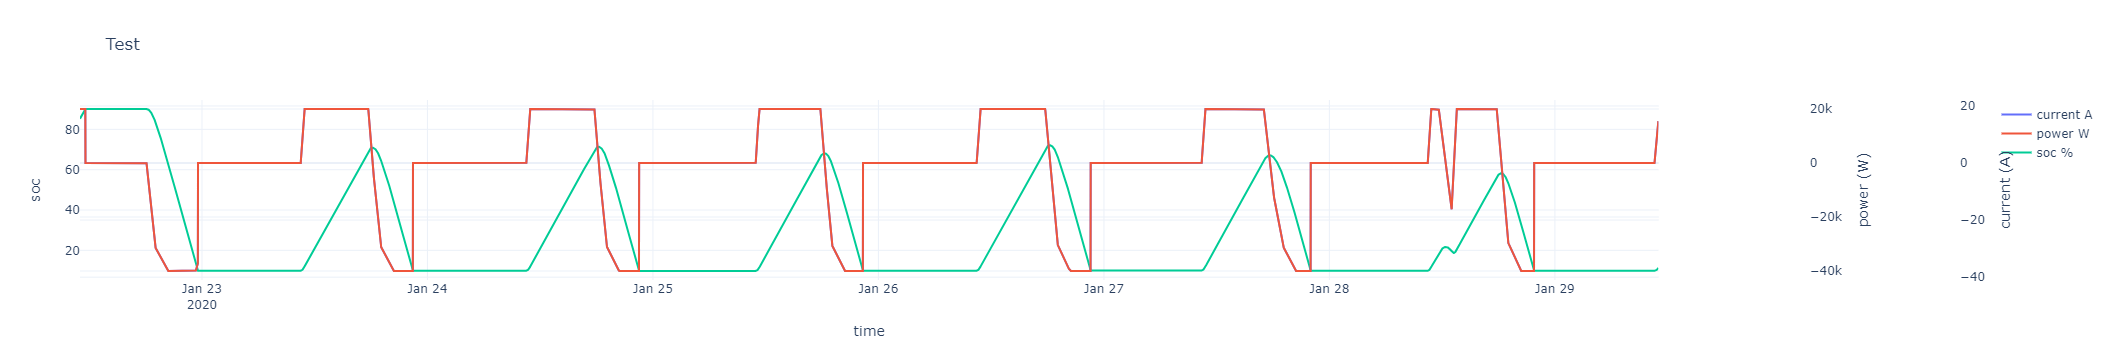

In [160]:
df = dataframeFromSensors(batterySensors)
fig = plotSensors(batterySensors, df, "Test")
fig.show()

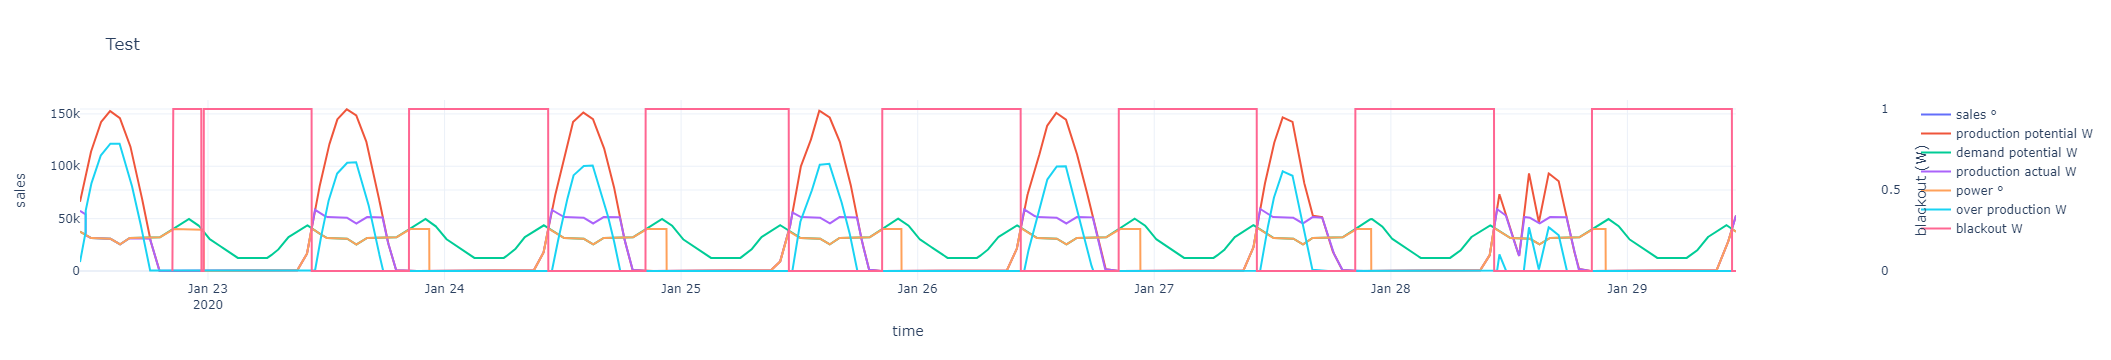

In [161]:
df = dataframeFromSensors(pPlantSensors)
fig = plotSensors(pPlantSensors, df, "Test")
fig.show()